In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

- ## Estimation(추정)

---

- ## Percentiles (백분위 수)
    - #### 숫자 데이터를 정렬했을 때 특정 순위의 값
    - #### 과정
        - #### 1. 오름차순으로 집합 원소 정렬
        - ### 2. $k = \frac{p}{100} * n$
            - #### 정수이면 정렬된 집합의 k번째 요소
            - #### 정수가 아니면 올림하고 정렬된 집합의 k번째 요소

<br><br>

- ### 70번째 백분위 수

<br>

- #### 1. 5개 중 70%는 3.5개 요소이므로 4번째 요소를 취함 => 12

In [2]:
sizes = make_array(12, 17, 6, 9, 7)
sizes = np.sort(sizes)
sizes

array([ 6,  7,  9, 12, 17], dtype=int64)

- #### 2. percentile(rank, 배열) 함수
    - #### 배열에 일치하는 백분위 수를 반환

In [3]:
percentile(70, sizes)

12

<br><br>

- ### 359명의 중간고사 점수 분포에서 85번째 백분위 수 찾기

In [5]:
scores_and_sections = Table.read_table("./csv/scores_by_section.csv")
scores = scores_and_sections.column(1)
scores_and_sections

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


- #### 1. percentile 사용

In [5]:
percentile(85, scores_and_sections.column(1))

22

- #### 2. k 사용

In [10]:
sorted_scores = np.sort(scores_and_sections.column(1))
k = (85 / 100) * scores_and_sections.num_rows
k = round(k)
k

305

In [11]:
sorted_scores.item(k)

22

- #### 22 이상의 전체 비율

In [15]:
np.count_nonzero(sorted_scores >= 22) / scores_and_sections.num_rows

0.17270194986072424

---

- ## 사분위 수

- #### 상위 20퍼센트는 모두 20점 이상임

In [6]:
percentile(75, scores)

20

---

- ## Bootstrap
    - ### 샘플로 모집단의 매개변수 값 추정하기 위한 목적
    - ### 전수조사 하기 힘들기 때문

    <br>
    
    - ### 모잡단에서 추출한 표본에 대한 데이터 중 1개만 가지고있는 상황
    - ### 가지고 있는 샘플에서 새로운 무작위 샘플 생성

<br><br>

- ### 모집단 데이터

In [2]:
sf2019 = Table.read_table("./csv/san_francisco_2019.csv")
sf2019.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


- #### 시장의 월급

In [3]:
sf2019.where("Job", are.equal_to("Mayor"))

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Mayor,Administrative & Mgmt (Unrep),Mayor,342974,0,98012,440987


- #### 입사한지 얼마 되지 않은 사람 제외하기 위하여 급여가 15000달러 이상인 사람만을 추출

In [4]:
sf2019 = sf2019.where("Salary", are.above(15000))
print(sf2019.num_rows)
sf2019.show(3)

37103


Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


- #### 전체 보상 분포

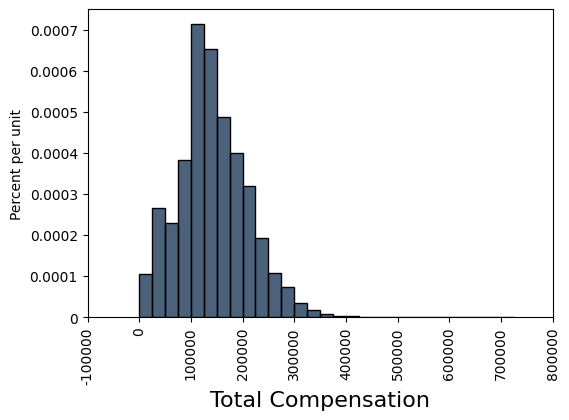

In [15]:
sf2019.select("Total Compensation").hist(bins=np.arange(0, 726000, 25000))

- #### 높은 일부를 확인하기 위하여 테이블 Total Compensation 기준 내림차순으로 정렬

In [17]:
sf2019.sort("Total Compensation", descending=True).show(2)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633,0,146398,724031
General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072,0,134879,617951


- #### 모집단 전체의 중앙값 확인

In [18]:
percentile(50, sf2019.column("Total Compensation"))

135747.0

<br>

- ### 500명의 무작위 샘플의 중앙값 확인
    - #### 평균의 원리
        - #### 샘플 수가 클수록 모집단의 분포와 샘플의 분포 유사
    - #### 모집단의 히스토그램과 중앙값과 유사

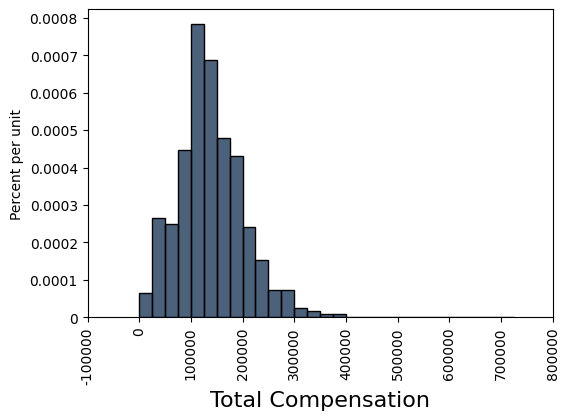

In [19]:
our_sample = sf2019.sample(500, with_replacement=False)
our_sample.select("Total Compensation").hist(bins=np.arange(0, 726000, 25000))

In [21]:
percentile(50, our_sample.column("Total Compensation"))

132257.0

<br>

- ### Original Sample(모집단에서 뽑은 샘플) 에서 Resample 진행
    - #### 중복 허용하여 샘플 뽑기
    - #### 모집단 분포와 유사

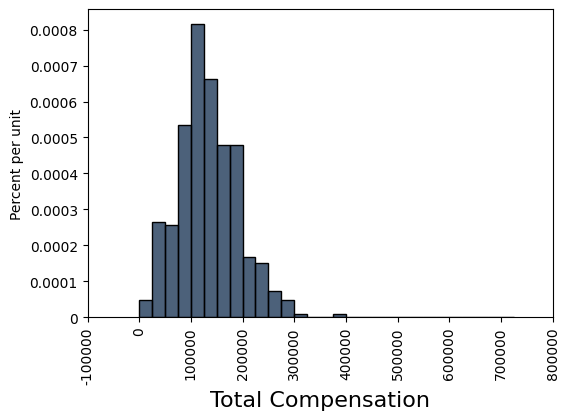

In [22]:
resample_1 = our_sample.sample()
resample_1.select("Total Compensation").hist(bins=np.arange(0, 726000, 25000))

In [23]:
resampled_median_1 = percentile(50, resample_1.column("Total Compensation"))
resampled_median_1

128067.0

<br>

- ### 5000번 반복 실행

In [25]:
def one_bootstrap_median():
    resample = our_sample.sample()
    return percentile(50, resample.column("Total Compensation"))

bstrap_medians = make_array()
for _ in range(5000):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

bstrap_medians

array([ 128241.,  133380.,  134884., ...,  132343.,  134684.,  132525.])

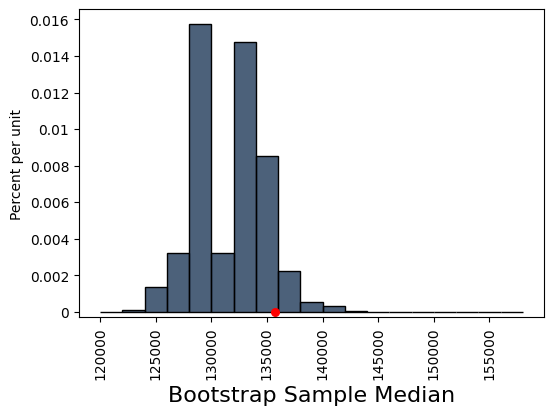

In [36]:
resampled_medians = Table().with_column("Bootstrap Sample Median", bstrap_medians)
resampled_medians.hist(bins=np.arange(120000, 160000, 2000))

orig_median = percentile(50, sf2019.column("Total Compensation"))
plt.ylim(-0.000003)
plt.scatter(orig_median, 0, color="red", s=30)

<br>

- ### 모집단의 중앙값이 리샘플의 중앙 95% 구간에 있을 확률
    - #### 5000번 시뮬레이션 한 것의 중앙 95% 구간을 100번 추출
    - #### 100개 중 모집단의 중앙값이 95% 구간 내 포함된 것은 몇개인가

In [17]:
left_ends = make_array()
right_ends = make_array()

def get_simulated_medians():
    curr_sample = sf2019.sample(500, with_replacement=False)
    medians = make_array()
    for _ in range(5000):
        curr_resample = curr_sample.sample()
        medians = np.append(medians, percentile(50, curr_resample.column("Total Compensation")))
    return medians

for _ in range(100):
    simulated_medians = get_simulated_medians()
    left_ends = np.append(left_ends, percentile(2.5, simulated_medians))
    right_ends = np.append(right_ends, percentile(97.5, simulated_medians))

intervals = Table().with_columns(
    "Left", left_ends,
    "Right", right_ends
)
intervals.show(3)

Left,Right
124761,139813
131456,148817
130106,141175


In [20]:
pop_median = percentile(50, sf2019.column("Total Compensation"))
print("모집단의 중앙값: ", pop_median)

intervals.where("Left", are.below(pop_median)).where("Right", are.above(pop_median))

모집단의 중앙값:  135747.0


Left,Right
124761,139813
131456,148817
130106,141175
125799,139041
133295,143155
133893,149046
128604,138491
125388,137780
130737,143806
127665,138544


In [22]:
intervals.where("Left", are.below(pop_median)).where("Right", are.above(pop_median)).num_rows

93